# Лабораторная работа №8

## Рекуррентные нейронные сети для анализа временных рядов

Набор данных для прогнозирования временных рядов, который состоит из среднемесячного числа пятен на солнце, наблюдаемых с января 1749 по август 2017.

Данные в виде csv-файла можно скачать на сайте _Kaggle_: https://www.kaggle.com/robervalt/sunspots/

### Задание 1

Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).

In [0]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [0]:
BASE_DIR = '/content/drive/My Drive/Colab Files/mo-2'

import sys

sys.path.append(BASE_DIR)

import os

In [0]:
DATA_ARCHIVE_NAME = 'sunspots.zip'

LOCAL_DIR_NAME = 'sunspots'

In [0]:
from zipfile import ZipFile

with ZipFile(os.path.join(BASE_DIR, DATA_ARCHIVE_NAME), 'r') as zip_:
    zip_.extractall(LOCAL_DIR_NAME)

In [0]:
DATA_FILE_PATH = 'sunspots/Sunspots.csv'

In [0]:
import pandas as pd

all_df = pd.read_csv(DATA_FILE_PATH, parse_dates = ['Date'], index_col = 'Date')

In [8]:
print(all_df.shape)

(3252, 2)


In [9]:
all_df.keys()

Index(['Unnamed: 0', 'Monthly Mean Total Sunspot Number'], dtype='object')

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

additive = seasonal_decompose(all_df['Monthly Mean Total Sunspot Number'],
                              model = 'additive', extrapolate_trend = 'freq')

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 8

sns.set()
sns.set_palette(sns.color_palette('hls'))

def plot_loss(_history):

    plt.plot(_history.history['loss'])
    plt.plot(_history.history['val_loss'])

    plt.title('Model loss')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.legend(['Train', 'Validation'], loc = 'right')

    plt.show()

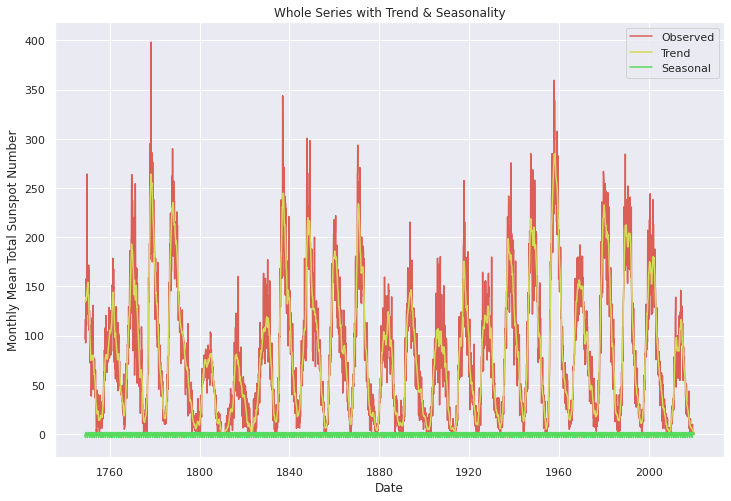

In [12]:
sns.lineplot(data = additive.observed, label = 'Observed')
sns.lineplot(data = additive.trend, label = 'Trend')
sns.lineplot(data = additive.seasonal, label = 'Seasonal')

plt.xlabel('Date')
plt.ylabel('Monthly Mean Total Sunspot Number')

plt.title('Whole Series with Trend & Seasonality')

plt.show()

Рассмотрим подробнее на небольшом промежутке:

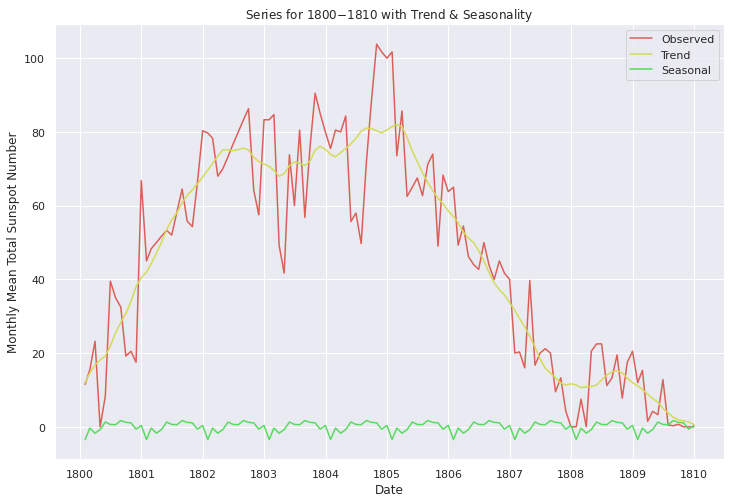

In [13]:
sns.lineplot(data = additive.observed['1800-01-01':'1810-01-01'], label = 'Observed')
sns.lineplot(data = additive.trend['1800-01-01':'1810-01-01'], label = 'Trend')
sns.lineplot(data = additive.seasonal['1800-01-01':'1810-01-01'], label = 'Seasonal')

plt.xlabel('Date')
plt.ylabel('Monthly Mean Total Sunspot Number')

plt.title('Series for 1800$-$1810 with Trend & Seasonality')

plt.show()

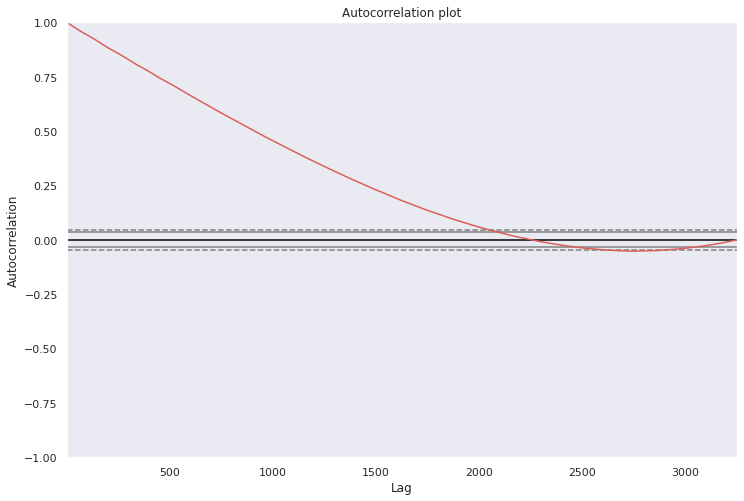

In [14]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(all_df.values.tolist())

plt.title('Autocorrelation plot')

plt.show()

### Задание 2

Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.

Этот шаг будет применён автоматически с помощью индексации массива данных и как параметр `validation_split` метода `model.fit()`.

### Задание 3

Примените модель _ARIMA_ для прогнозирования значений данного временного ряда.

In [0]:
! pip install pmdarima --quiet

In [16]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(all_df['Monthly Mean Total Sunspot Number'].values,
              order = (1, 0, 2))

model_fit = model.fit(disp = 0)

print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3252
Model:                     ARMA(1, 2)   Log Likelihood              -15098.879
Method:                       css-mle   S.D. of innovations             25.120
Date:                Mon, 20 Apr 2020   AIC                          30207.757
Time:                        04:10:50   BIC                          30238.192
Sample:                             0   HQIC                         30218.660
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.1334     11.977      6.774      0.000      57.660     104.607
ar.L1.y        0.9826      0.003    284.234      0.000       0.976       0.989
ma.L1.y       -0.4063      0.018    -22.947      0.0

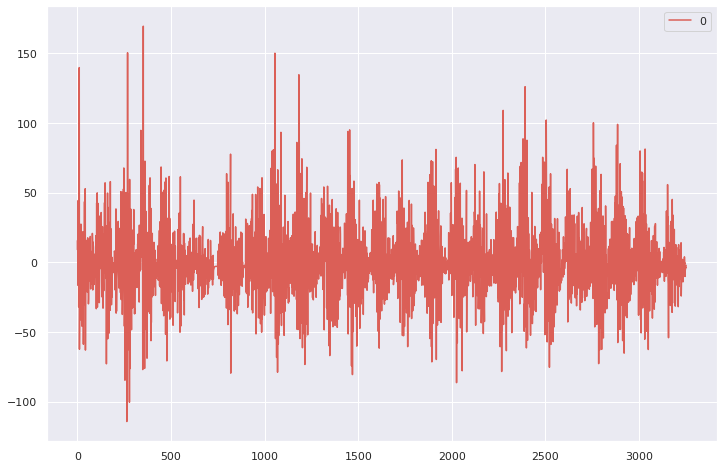

In [17]:
residuals = pd.DataFrame(model_fit.resid)

residuals.plot()

plt.show()

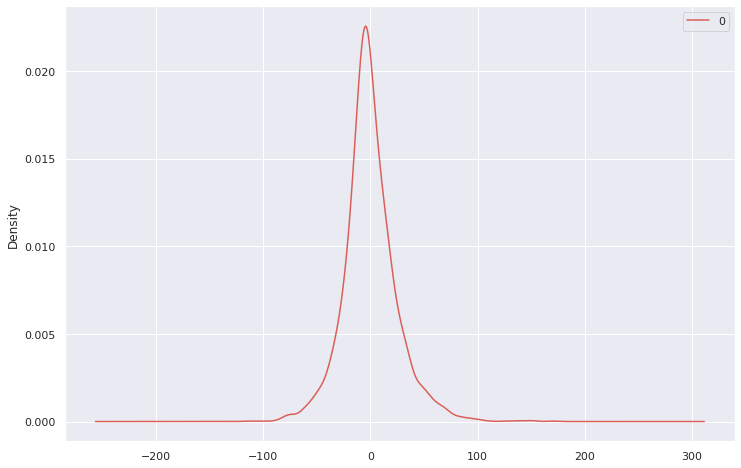

In [18]:
residuals.plot(kind = 'kde')

plt.show()

### Задание 4

Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).

Сначала нужно создать датасет из данных.

In [0]:
TEST_PERIOD = 600

In [0]:
OBSERVATIONS_PER_CYCLE = 11 * 12

In [0]:
TIME_STEPS = OBSERVATIONS_PER_CYCLE

In [0]:
! pip install tensorflow-gpu --pre --quiet

In [0]:
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow import keras

In [0]:
import numpy as np
from datetime import timezone

def timeseries_to_dataset(_X_ts, _time_steps):

    samples_n_ = len(_X_ts) - _time_steps

    _X_norm = tf.keras.utils.normalize(_X_ts).squeeze()

    print(_X_ts.shape, _X_norm.shape)

    X_ = np.zeros((samples_n_, _time_steps))
    y_ = np.zeros((samples_n_, ))

    for i in range(samples_n_):

        X_[i] = _X_norm[i:(i + _time_steps)]

        y_[i] = _X_norm[(i + _time_steps)]

    return X_[..., np.newaxis], y_

In [25]:
X_as_ds, y_as_ds = timeseries_to_dataset(
    all_df['Monthly Mean Total Sunspot Number'].values,
    TIME_STEPS)

X, y = X_as_ds[:-TEST_PERIOD], y_as_ds[:-TEST_PERIOD]

X_test, y_test = X_as_ds[-TEST_PERIOD:], y_as_ds[-TEST_PERIOD:]

(3252,) (3252,)


In [26]:
print(X.shape, X_test.shape, y.shape, y_test.shape)

(2520, 132, 1) (600, 132, 1) (2520,) (600,)


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = tf.keras.Sequential()

model.add(LSTM(2, activation = 'relu', return_sequences = True,
               input_shape = X.shape[-2:]))
model.add(LSTM(12, activation = 'relu'))
model.add(Dense(1))

In [28]:
model.compile(optimizer = 'adam',
              loss = 'mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 132, 2)            32        
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                720       
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 765
Trainable params: 765
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x = X, y = y, epochs = 20, validation_split = 0.15,
                    verbose = 0)

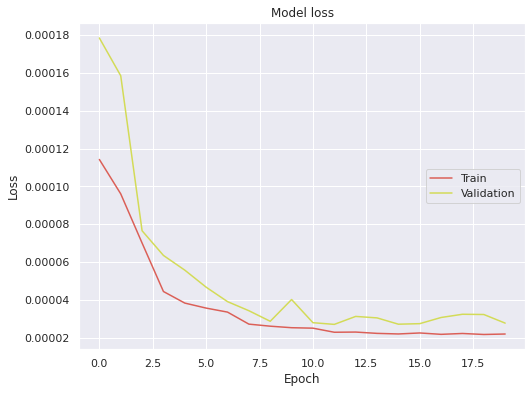

In [30]:
rcParams['figure.figsize'] = 8, 6

plot_loss(history)

In [31]:
results = model.evaluate(X_test, y_test)

print('Test mse:', results)

19/19 [==============================] - 0s 26ms/step - loss: 1.9438e-05
Test mse: 1.9438315575825982e-05


In [32]:
y_pred = model.predict(X_test[20][np.newaxis, ...])

print(y_pred, y_test[20])

[[0.01421428]] 0.011741172416758197


### Задание 5

Сравните качество прогноза моделей.

Какой максимальный результат удалось получить на контрольной выборке?